In [64]:
import pandas as pd
import numpy as np
from functions import dataloader, add_features, data_split, scale, plot_model_comparison, plot_train_test_predictions
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


# Data Preprocessing

In [65]:
df = dataloader()
df = add_features(df)

f:\Time-Series-Forecasting\functions.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_return = df['Close'].resample('M').ffill().pct_change().shift(1)
f:\Time-Series-Forecasting\functions.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_return = monthly_return.fillna(method='bfill')


In [66]:
features = [
    'MA5', 'MA10', 'MA20', 'Momentum_1d', 
    'Momentum_5d', 'Monthly_Return', 'Open', 'High', 'Low', 'Close'
]


In [67]:
X = df[features]
y = df['target']

In [68]:
X = X.to_numpy()
y = y.to_numpy()

# Data Splitting

In [69]:
# Split data

test_size = 0.2
X_train, X_test, y_train, y_test = data_split(X, y, test_size=test_size)

# Calculate split index for plotting
split_idx = int(len(df) * (1 - test_size))



# Data Scaling

In [70]:
# Scale data

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler = scale(X_train, X_test, y_train, y_test)

In [71]:
X_train.shape

(1802, 10)

In [72]:
# Set style for plots
plt.style.use('dark_background')


model_results = {}
models = {}



In [73]:
# Get actual test prices
y_test_original = df['target'][split_idx:].values

# Machine Learning Models

In [74]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression


lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_scaled)
lr_pred_scaled = lr_model.predict(X_test_scaled)
lr_pred = y_scaler.inverse_transform(lr_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
lr_mse = mean_squared_error(y_test_scaled, lr_pred_scaled)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test_scaled, lr_pred_scaled)
lr_r2 = r2_score(y_test_scaled, lr_pred_scaled)

model_results['Linear Regression'] = {
    'MSE': lr_mse,
    'RMSE': lr_rmse,
    'MAE': lr_mae,
    'R²': lr_r2
}
models['Linear Regression'] = lr_model

print("Linear Regression Model Performance:")
for metric, value in model_results['Linear Regression'].items():
    print(f"{metric}: {value:.4f}")

Linear Regression Model Performance:
MSE: 0.0005
RMSE: 0.0212
MAE: 0.0157
R²: 0.9714



Plotting results for Linear Regression model


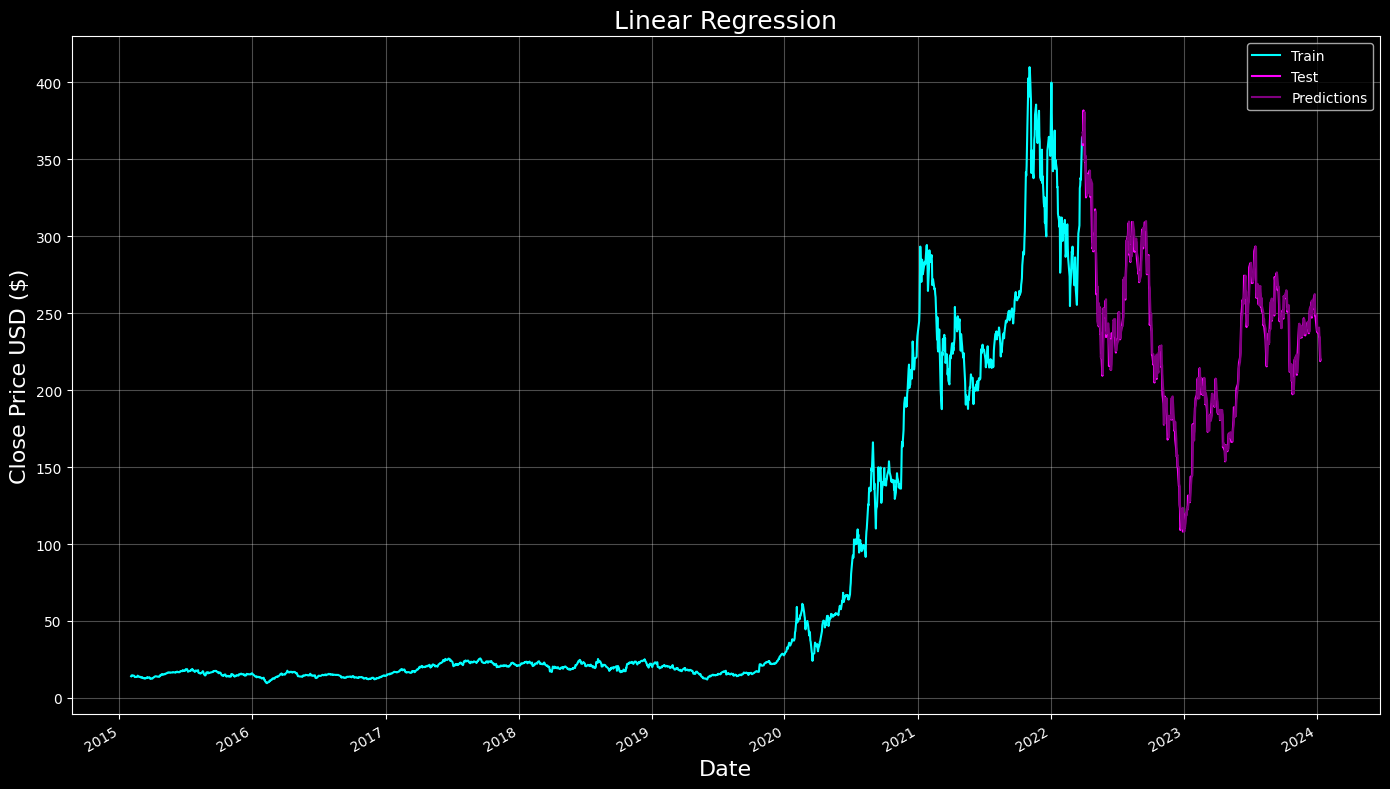

In [75]:
print(f"\nPlotting results for Linear Regression model")
plot_train_test_predictions(df, split_idx, y_test_original, lr_pred, model_name="Linear Regression")

In [76]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_scaled)
rf_pred_scaled = rf_model.predict(X_test_scaled)
rf_pred = y_scaler.inverse_transform(rf_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
rf_mse = mean_squared_error(y_test_scaled, rf_pred_scaled)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test_scaled, rf_pred_scaled)
rf_r2 = r2_score(y_test_scaled, rf_pred_scaled)

model_results['Random Forest'] = {
    'MSE': rf_mse,
    'RMSE': rf_rmse,
    'MAE': rf_mae,
    'R²': rf_r2
}
models['Random Forest'] = rf_model

print("Random Forest Model Performance:")
for metric, value in model_results['Random Forest'].items():
    print(f"{metric}: {value:.4f}")

Random Forest Model Performance:
MSE: 0.0008
RMSE: 0.0291
MAE: 0.0222
R²: 0.9461



Plotting results for Random Forest model


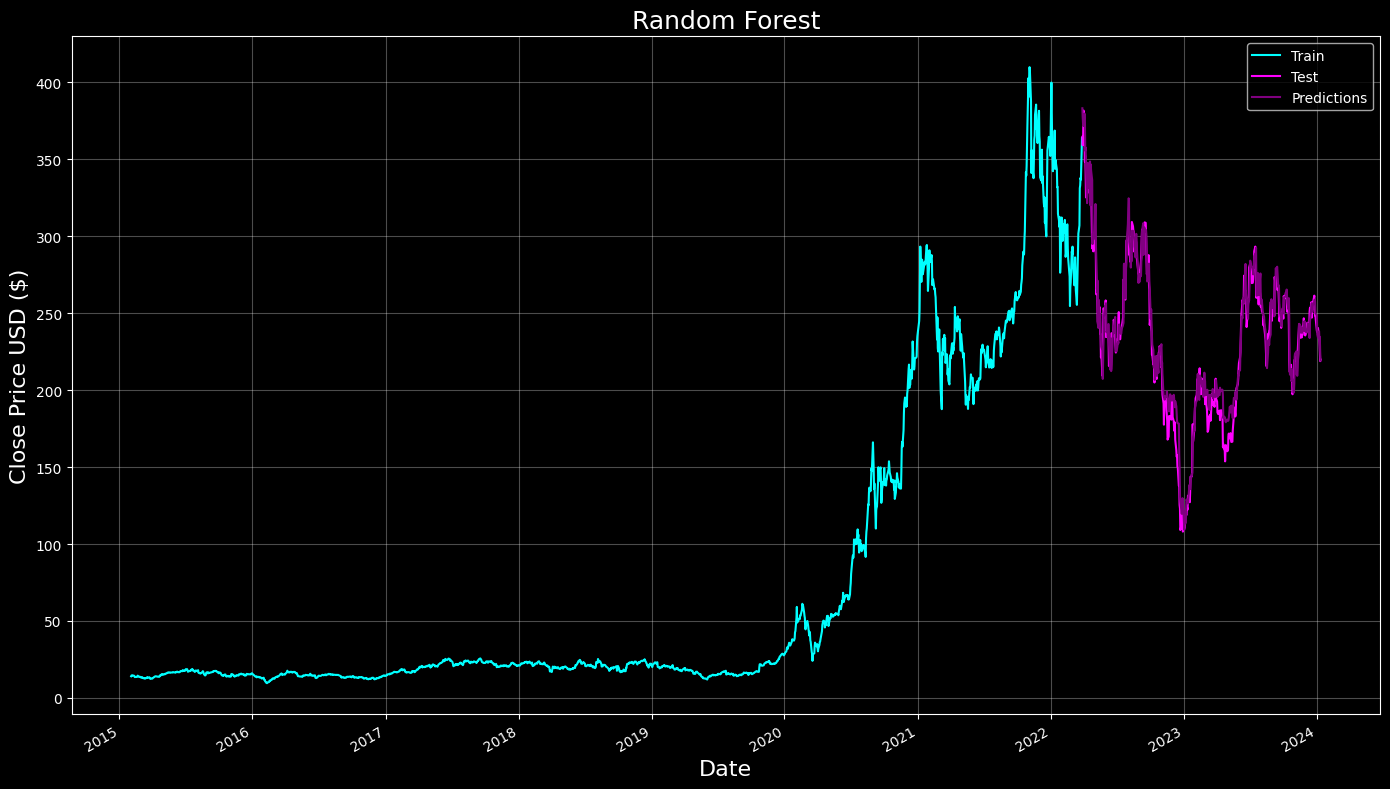

In [77]:
print(f"\nPlotting results for Random Forest model")
plot_train_test_predictions(df, split_idx, y_test_original, rf_pred, model_name="Random Forest")

In [78]:
# XGBoost Model
import xgboost as xgb


xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train_scaled)
xgb_pred_scaled = xgb_model.predict(X_test_scaled)
xgb_pred = y_scaler.inverse_transform(xgb_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
xgb_mse = mean_squared_error(y_test_scaled, xgb_pred_scaled)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test_scaled, xgb_pred_scaled)
xgb_r2 = r2_score(y_test_scaled, xgb_pred_scaled)

model_results['XGBoost'] = {
    'MSE': xgb_mse,
    'RMSE': xgb_rmse,
    'MAE': xgb_mae,
    'R²': xgb_r2
}
models['XGBoost'] = xgb_model

print("XGBoost Model Performance:")
for metric, value in model_results['XGBoost'].items():
    print(f"{metric}: {value:.4f}")


XGBoost Model Performance:
MSE: 0.0008
RMSE: 0.0279
MAE: 0.0217
R²: 0.9505



Plotting results for XGBoost


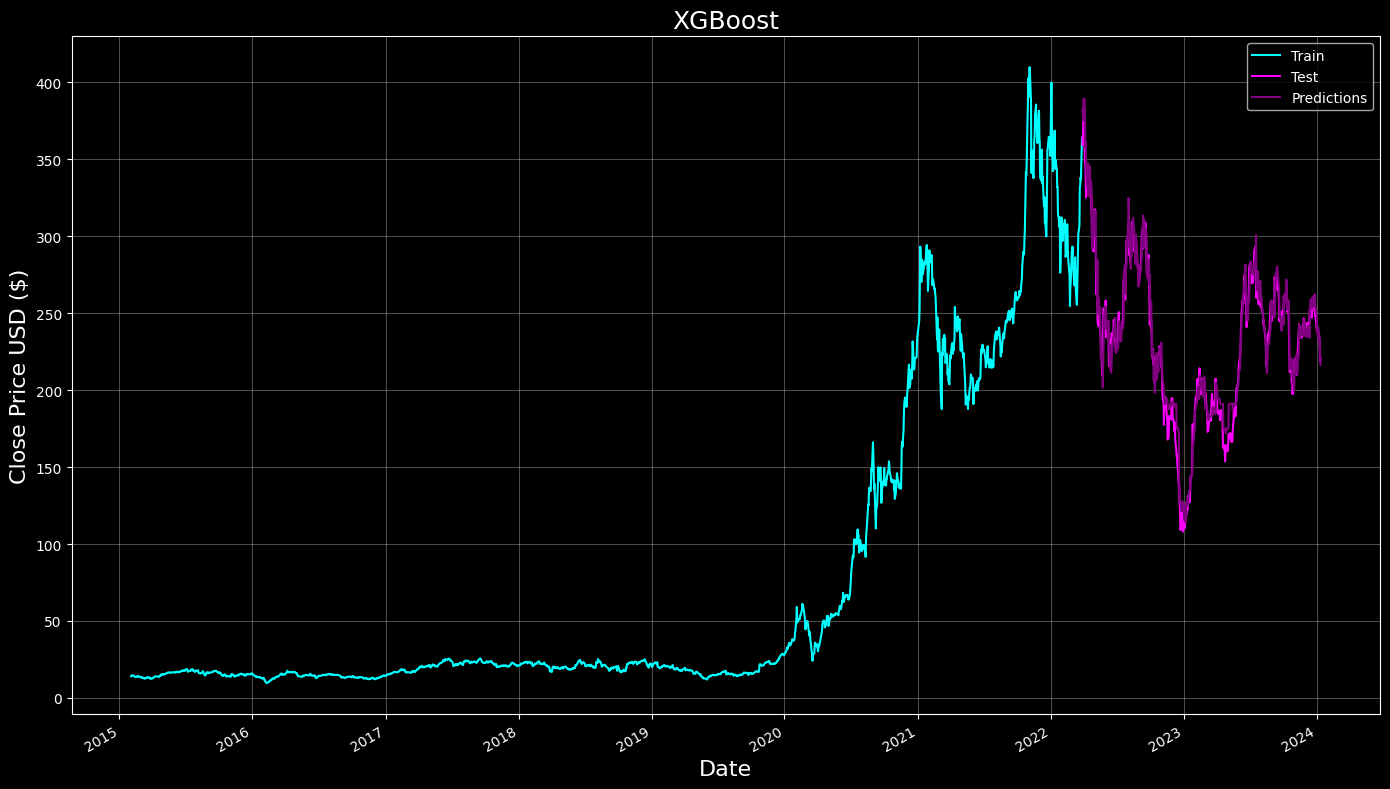

In [79]:
print(f"\nPlotting results for XGBoost")
plot_train_test_predictions(df, split_idx, y_test_original, xgb_pred, model_name="XGBoost")

In [80]:
# Decision Tree Model
from sklearn.tree import DecisionTreeRegressor


dt_model = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dt_model.fit(X_train_scaled, y_train_scaled)
dt_pred_scaled = dt_model.predict(X_test_scaled)
dt_pred = y_scaler.inverse_transform(dt_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
dt_mse = mean_squared_error(y_test_scaled, dt_pred_scaled)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(y_test_scaled, dt_pred_scaled)
dt_r2 = r2_score(y_test_scaled, dt_pred_scaled)

model_results['Decision Tree'] = {
    'MSE': dt_mse,
    'RMSE': dt_rmse,
    'MAE': dt_mae,
    'R²': dt_r2
}
models['Decision Tree'] = dt_model

print("Decision Tree Model Performance:")
for metric, value in model_results['Decision Tree'].items():
    print(f"{metric}: {value:.4f}")

Decision Tree Model Performance:
MSE: 0.0015
RMSE: 0.0392
MAE: 0.0290
R²: 0.9024



Plotting results for Decision Tree model


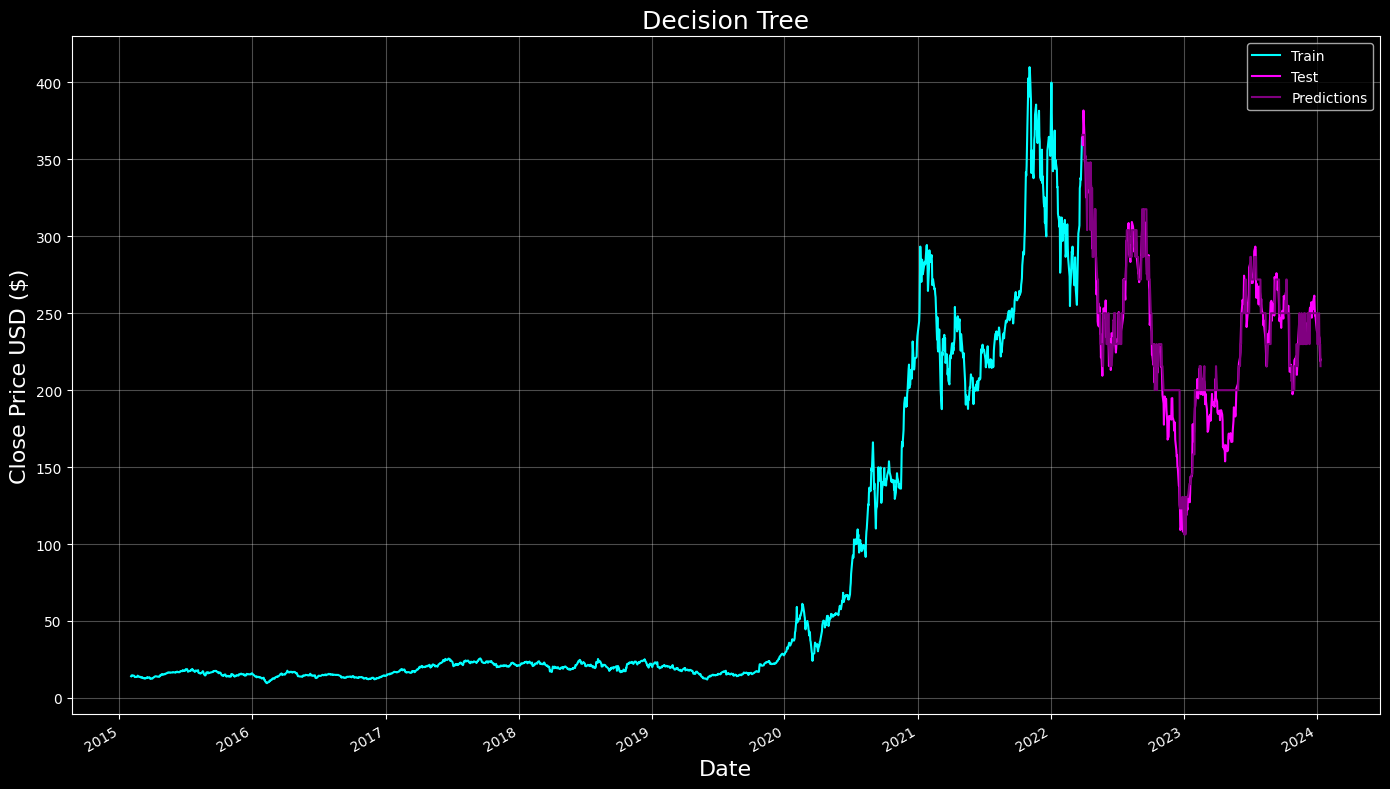

In [81]:
print(f"\nPlotting results for Decision Tree model")
plot_train_test_predictions(df, split_idx, y_test_original, dt_pred, model_name="Decision Tree")

In [82]:
# SVR Model (New Addition)
from sklearn.svm import SVR


svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train_scaled)
svr_pred_scaled = svr_model.predict(X_test_scaled)
svr_pred = y_scaler.inverse_transform(svr_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
svr_mse = mean_squared_error(y_test_scaled, svr_pred_scaled)
svr_rmse = np.sqrt(svr_mse)
svr_mae = mean_absolute_error(y_test_scaled, svr_pred_scaled)
svr_r2 = r2_score(y_test_scaled, svr_pred_scaled)

model_results['SVR'] = {
    'MSE': svr_mse,
    'RMSE': svr_rmse,
    'MAE': svr_mae,
    'R²': svr_r2
}
models['SVR'] = svr_model

print("SVR Model Performance:")
for metric, value in model_results['SVR'].items():
    print(f"{metric}: {value:.4f}")

SVR Model Performance:
MSE: 0.0014
RMSE: 0.0368
MAE: 0.0306
R²: 0.9141



Plotting results for SVR model


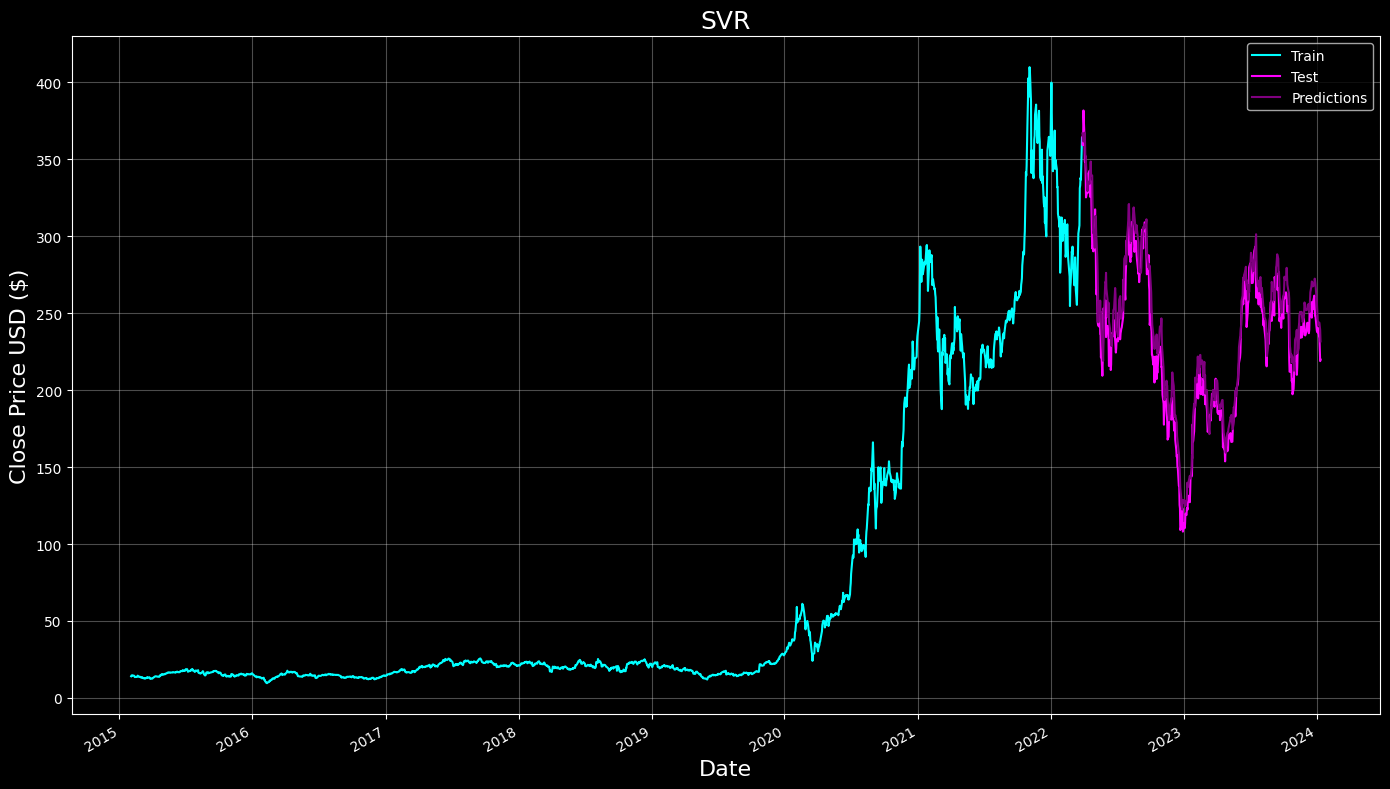

In [83]:
print(f"\nPlotting results for SVR model")
plot_train_test_predictions(df, split_idx, y_test_original, svr_pred, model_name="SVR")


Plotting model comparison...


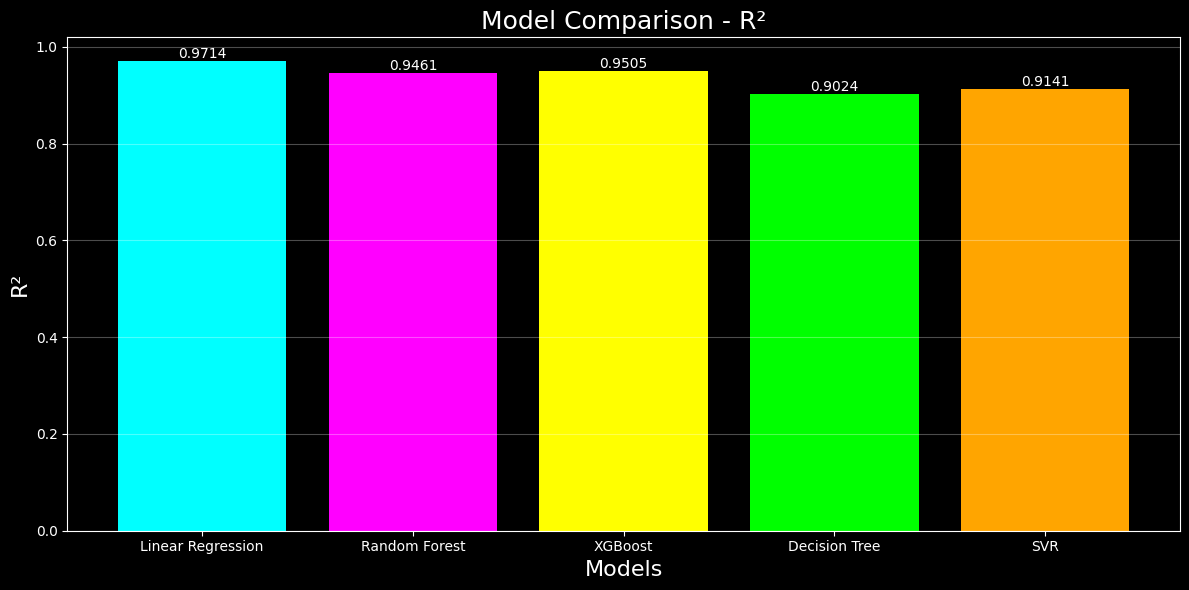

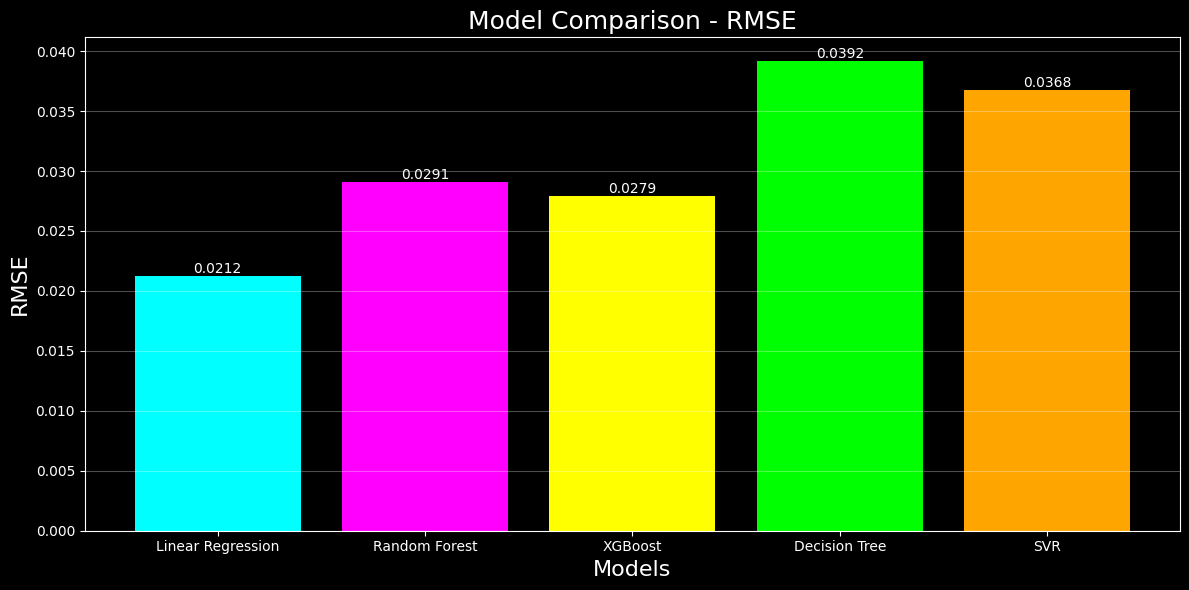

In [84]:


# Plot the model with the best R² score
best_model_name = max(model_results, key=lambda x: model_results[x]['R²'])
best_model = models[best_model_name]
best_pred_scaled = best_model.predict(X_test_scaled)
best_pred = y_scaler.inverse_transform(best_pred_scaled.reshape(-1, 1)).flatten()

# print(f"\nPlotting results for best model: {best_model_name}")
# plot_train_test_predictions(df, split_idx, y_test_original, best_pred, model_name=best_model_name)

# Plot model comparison
print("\nPlotting model comparison...")
plot_model_comparison(model_results)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
# New imports for time series models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# import statsmodels.api as sm
# from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima
# from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('dark_background')

def dataloader():
    df = pd.read_csv('./Tasla_Stock_Updated_V2.csv')  
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.dropna()
    return df

def add_features(df):
    df = df.copy()
    # Technical indicators that don't use future information
    df['MA5'] = df['Close'].rolling(window=5).mean().shift(1)
    df['MA10'] = df['Close'].rolling(window=10).mean().shift(1)
    df['MA20'] = df['Close'].rolling(window=20).mean().shift(1)
    df['Volatility'] = df['Close'].rolling(window=10).std().shift(1)
    
    # Price momentum features
    df['Momentum_1d'] = df['Close'].pct_change(periods=1).shift(1)
    df['Momentum_5d'] = df['Close'].pct_change(periods=5).shift(1)
    
    # Monthly Return (without using future information)
    monthly_return = df['Close'].resample('M').ffill().pct_change().shift(1)
    monthly_return = monthly_return.fillna(method='bfill')
    df['Monthly_Return'] = monthly_return.resample('D').ffill().reindex(df.index, method='ffill')
    
    # Target: next day's closing price
    df['target'] = df['Close'].shift(-1)
    
    # Remove rows with missing values
    df.dropna(inplace=True)
    return df

def data_split(X, y, test_size=0.2, sort_key=None):
    """
    Split data into training and testing sets, with option to sort first.
    """
    # Convert inputs to numpy arrays if they aren't already
    X = np.array(X)
    y = np.array(y)
    
    # Check if the lengths match
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    
    # Create indices array
    indices = np.arange(len(X))
    
    # Sort the indices if a sort key is provided
    if sort_key is not None:
        if callable(sort_key):
            # Use the provided function as the sort key
            sorted_indices = sorted(indices, key=lambda i: sort_key(X[i]))
        elif isinstance(sort_key, int):
            # Sort based on a specific column in X
            sorted_indices = sorted(indices, key=lambda i: X[i][sort_key])
        else:
            raise ValueError("sort_key must be either a callable or an integer")
        
        # Reorder X and y based on the sorted indices
        X = X[sorted_indices]
        y = y[sorted_indices]
    
    # Calculate the split point
    split_idx = int(len(X) * (1 - test_size))
    
    # Split the data (earlier data for training, later data for testing)
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    return X_train, X_test, y_train, y_test

def scale(X_train, X_test, y_train, y_test):
    """
    Scale the input features and target values using MinMaxScaler.
    """
    # Scale features
    X_scaler = MinMaxScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Scale target
    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler

def plot_train_test_predictions(df, split_idx, y_test, y_pred, model_name='Model'):
    """
    Plot train, test and prediction data
    """
    plt.figure(figsize=(14, 8))
    
    # Get the dates
    train_dates = df.index[:split_idx]
    test_dates = df.index[split_idx:]
    
    # Plot training data
    plt.plot(train_dates, df['Close'][:split_idx], color='cyan', label='Train')
    
    # Plot test data
    plt.plot(test_dates, y_test, color='magenta', label='Test')
    
    # Plot predictions
    plt.plot(test_dates, y_pred, color='purple', label='Predictions')
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Set labels and title
    plt.title(model_name, fontsize=18)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Close Price USD ($)', fontsize=16)
    
    # Add legend
    plt.legend(loc='best')
    
    # Format x-axis dates
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

def plot_model_comparison(results):
    """
    Create bar charts comparing model performance metrics
    """
    # Select metrics to display
    metrics_to_plot = ['R²', 'RMSE']
    
    for metric in metrics_to_plot:
        plt.figure(figsize=(14, 7))
        
        # Extract metric values for each model
        models = list(results.keys())
        values = [results[model][metric] for model in models]
        
        # Different colors for each bar
        colors = ['cyan', 'magenta', 'yellow', 'lime', 'orange', 'violet', 'turquoise', 'gold', 'pink']
        
        # Create bar chart
        bars = plt.bar(models, values, color=colors[:len(models)])
        
        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', rotation=0, color='white')
        
        plt.title(f'Model Comparison - {metric}', fontsize=18)
        plt.ylabel(metric, fontsize=16)
        plt.xlabel('Models', fontsize=16)
        plt.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# New function to prepare data for sequence models (LSTM, GRU)
def create_sequences(X, y, time_steps=1):
    """
    Create sequences of time_steps for sequence models like LSTM and GRU
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# LSTM model creation function
def create_lstm_model(input_shape):
    """
    Create and compile LSTM model
    """
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# GRU model creation function
def create_gru_model(input_shape):
    """
    Create and compile GRU model
    """
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def main():
    # Load and prepare data
    print("Loading data...")
    df = dataloader()
    df = add_features(df)
    
    # Define features and target
    features = [
        'MA5', 'MA10', 'MA20', 'Momentum_1d', 
        'Momentum_5d', 'Monthly_Return', 'Open', 'High', 'Low', 'Close'
    ]
    
    X = df[features]
    y = df['target']
    
    X = X.to_numpy()
    y = y.to_numpy()
    
    # Split data
    print("Splitting data...")
    test_size = 0.2
    X_train, X_test, y_train, y_test = data_split(X, y, test_size=test_size)
    
    # Calculate split index for plotting
    split_idx = int(len(df) * (1 - test_size))
    
    # Scale data
    print("Scaling data...")
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler = scale(X_train, X_test, y_train, y_test)
    
    # Store model performances
    model_results = {}
    models = {}
    

    
 
    
    # -------------------------------------------------
    # LSTM Model 
    # -------------------------------------------------
    print("\nPreparing data for LSTM model...")
    # Create sequences for LSTM (timesteps=10)
    time_steps = 10
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)
    
    # Reshape for LSTM [samples, time steps, features]
    X_train_lstm = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2])
    X_test_lstm = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2])
    
    print("\nTraining LSTM model...")
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Create and train LSTM model
    lstm_model = create_lstm_model((time_steps, X_train.shape[1]))
    lstm_history = lstm_model.fit(
        X_train_lstm, y_train_seq,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Make predictions
    lstm_pred_seq = lstm_model.predict(X_test_lstm)
    lstm_pred_scaled = lstm_pred_seq.flatten()
    
    # Handle potential length mismatch due to sequence creation
    y_test_lstm = y_test_seq
    
    # Metrics calculation
    lstm_mse = mean_squared_error(y_test_lstm, lstm_pred_scaled)
    lstm_rmse = np.sqrt(lstm_mse)
    lstm_mae = mean_absolute_error(y_test_lstm, lstm_pred_scaled)
    lstm_r2 = r2_score(y_test_lstm, lstm_pred_scaled)
    
    # Prepare predictions for plotting (inverse transform)
    # Handle potential length mismatch for plotting
    lstm_pred = y_scaler.inverse_transform(lstm_pred_scaled.reshape(-1, 1)).flatten()
    
    # Store results
    model_results['LSTM'] = {
        'MSE': lstm_mse,
        'RMSE': lstm_rmse,
        'MAE': lstm_mae,
        'R²': lstm_r2
    }
    models['LSTM'] = lstm_model
    
    print("LSTM Model Performance:")
    for metric, value in model_results['LSTM'].items():
        print(f"{metric}: {value:.4f}")
    
    # -------------------------------------------------
    # GRU Model 
    # -------------------------------------------------
    print("\nTraining GRU model...")
    # Create and train GRU model
    gru_model = create_gru_model((time_steps, X_train.shape[1]))
    gru_history = gru_model.fit(
        X_train_lstm, y_train_seq,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Make predictions
    gru_pred_seq = gru_model.predict(X_test_lstm)
    gru_pred_scaled = gru_pred_seq.flatten()
    
    # Metrics calculation
    gru_mse = mean_squared_error(y_test_lstm, gru_pred_scaled)
    gru_rmse = np.sqrt(gru_mse)
    gru_mae = mean_absolute_error(y_test_lstm, gru_pred_scaled)
    gru_r2 = r2_score(y_test_lstm, gru_pred_scaled)
    
    # Prepare predictions for plotting
    gru_pred = y_scaler.inverse_transform(gru_pred_scaled.reshape(-1, 1)).flatten()
    
    # Store results
    model_results['GRU'] = {
        'MSE': gru_mse,
        'RMSE': gru_rmse,
        'MAE': gru_mae,
        'R²': gru_r2
    }
    models['GRU'] = gru_model
    
    print("GRU Model Performance:")
    for metric, value in model_results['GRU'].items():
        print(f"{metric}: {value:.4f}")
    
    # # -------------------------------------------------
    # # ARIMA Model - NEW ADDITION
    # # -------------------------------------------------
    # print("\nTraining ARIMA model...")
    # # Get the target series for ARIMA
    # target_series = df['Close']
    
    # # Split data
    # train_series = target_series[:split_idx]
    # test_series = target_series[split_idx:]
    
    # # Use auto_arima to find the best parameters
    # print("Finding best ARIMA parameters...")
    # auto_model = auto_arima(
    #     train_series,
    #     seasonal=False,
    #     stepwise=True,
    #     suppress_warnings=True,
    #     max_p=5, max_q=5, max_d=2,
    #     trace=False,
    #     error_action="ignore",
    #     information_criterion="aic"
    # )
    
    # best_order = auto_model.order
    # print(f"Best ARIMA order: {best_order}")
    
    # # Fit ARIMA model with the best parameters
    # arima_model = ARIMA(train_series, order=best_order)
    # arima_fit = arima_model.fit()
    
    # # Forecast
    # arima_forecast = arima_fit.forecast(steps=len(test_series))
    
    # # Calculate metrics
    # arima_mse = mean_squared_error(test_series, arima_forecast)
    # arima_rmse = np.sqrt(arima_mse)
    # arima_mae = mean_absolute_error(test_series, arima_forecast)
    # arima_r2 = r2_score(test_series, arima_forecast)
    
    # model_results['ARIMA'] = {
    #     'MSE': arima_mse,
    #     'RMSE': arima_rmse,
    #     'MAE': arima_mae,
    #     'R²': arima_r2
    # }
    # models['ARIMA'] = arima_fit
    
    # print("ARIMA Model Performance:")
    # for metric, value in model_results['ARIMA'].items():
    #     print(f"{metric}: {value:.4f}")
    
    # # -------------------------------------------------
    # # SARIMA Model - NEW ADDITION
    # # -------------------------------------------------
    # print("\nTraining SARIMA model...")
    # # Try to find best SARIMA parameters (simple approach)
    # print("Finding best SARIMA parameters...")
    # auto_sarima = auto_arima(
    #     train_series,
    #     seasonal=True,
    #     m=5,  # Weekly seasonality (5 trading days)
    #     stepwise=True,
    #     suppress_warnings=True,
    #     max_p=2, max_q=2, max_d=1,
    #     max_P=1, max_Q=1, max_D=1,
    #     trace=False,
    #     error_action="ignore",
    #     information_criterion="aic"
    # )
    
    # best_order = auto_sarima.order
    # best_seasonal_order = auto_sarima.seasonal_order
    # print(f"Best SARIMA order: {best_order}")
    # print(f"Best SARIMA seasonal order: {best_seasonal_order}")
    
    # # Fit SARIMA model with the best parameters
    # sarima_model = SARIMAX(train_series, 
    #                       order=best_order, 
    #                       seasonal_order=best_seasonal_order)
    # sarima_fit = sarima_model.fit(disp=False)
    
    # # Forecast
    # sarima_forecast = sarima_fit.forecast(steps=len(test_series))
    
    # # Calculate metrics
    # sarima_mse = mean_squared_error(test_series, sarima_forecast)
    # sarima_rmse = np.sqrt(sarima_mse)
    # sarima_mae = mean_absolute_error(test_series, sarima_forecast)
    # sarima_r2 = r2_score(test_series, sarima_forecast)
    
    # model_results['SARIMA'] = {
    #     'MSE': sarima_mse,
    #     'RMSE': sarima_rmse,
    #     'MAE': sarima_mae,
    #     'R²': sarima_r2
    # }
    # models['SARIMA'] = sarima_fit
    
    # print("SARIMA Model Performance:")
    # for metric, value in model_results['SARIMA'].items():
    #     print(f"{metric}: {value:.4f}")
    
    # # Get actual test prices for plotting
    # y_test_original = df['target'][split_idx:].values
    
    # # Create forecasts for sequence models (LSTM and GRU)
    # # Need to adjust for time step difference
    # offset = time_steps
    # lstm_test_dates = df.index[split_idx+offset:split_idx+offset+len(lstm_pred)]
    # gru_test_dates = df.index[split_idx+offset:split_idx+offset+len(gru_pred)]
    
    # # Plot the models
    # # Plot LSTM
    # print("\nPlotting LSTM results...")
    # plt.figure(figsize=(14, 8))
    # plt.plot(df.index[:split_idx], df['Close'][:split_idx], color='cyan', label='Train')
    # plt.plot(df.index[split_idx:], df['Close'][split_idx:], color='magenta', label='Test')
    # plt.plot(lstm_test_dates, lstm_pred, color='purple', label='LSTM Predictions')
    # plt.title('LSTM Model', fontsize=18)
    # plt.xlabel('Date', fontsize=16)
    # plt.ylabel('Close Price USD ($)', fontsize=16)
    # plt.grid(True, alpha=0.3)
    # plt.legend(loc='best')
    # plt.gcf().autofmt_xdate()
    # plt.tight_layout()
    # plt.show()
    
if __name__ == "__main__":
    main()

Loading data...
Splitting data...
Scaling data...

Preparing data for LSTM model...

Training LSTM model...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
LSTM Model Performance:
MSE: 0.0026
RMSE: 0.0506
MAE: 0.0411
R²: 0.8157

Training GRU model...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
GRU Model Performance:
MSE: 0.0019
RMSE: 0.0432
MAE: 0.0345
R²: 0.8659
